# Dimensionality Reduction
In this best practices notebook, we will use the [QM7 data set](http://quantum-machine.org/datasets/) as a toy example to discuss and demonstrate the benefits of dimensionality reduction techniques in exploring the chemical space. The data set comprises 7165 organic molecules with diverse sizes (up to 13 heavy-atoms) and chemical compositions, featuring heavy elements such as C, N, O, and S. In addition to the three-dimensional molecular structures available either as standard Cartesian coordinates or in the Coulomb matrix representation, the QM7 data set also provides atomization energies for each compound calculated using density functional theory (DFT).

To run this notebook, you will need to use a kernel with the following libraries installed:
* RDKit
* Pandas
* ipykernel

## Setting up the environment
Below we install additional Python libraries you will need to run this notebook, and define a function for visualizing molecules which you will need later on:

In [ ]:
# Install and update required packages
!pip install pacmap -U
!pip install py3Dmol -U
!pip install scikit-learn -U
!pip install pandas -U
!pip install seaborn -U

In [2]:
import numpy as np

# Import libraries for data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt
import py3Dmol

%matplotlib inline

# Define function for visualization of molecules from file
def view_molecule(data, index, style):

    bohr2ang = 0.529177249
    symbols = {1:'H', 6:'C', 7:'N', 8:'O', 16: 'S'}

    idx_nonzero = data['Z'][index].nonzero()
    Z = data['Z'][index][idx_nonzero]
    n_atoms = Z.size
    labels = np.vectorize(symbols.get)(Z)
    labels = labels.reshape(-1,1)

    coords = data['R'][index][0:n_atoms,:].reshape(-1,3) * bohr2ang

    xyz = np.concatenate((labels, coords), axis=1)
    n_atoms = xyz.shape[0]
    xyz_str = [str(i).strip('[]') for i in xyz]
    geom = str(n_atoms) + '\n' + ' ' + '\n'
    geom += '\n'.join(xyz_str)
    geom = geom.replace("'", "")

    for k in style.keys():
        assert k in ('line', 'stick', 'sphere', 'carton')

    molview = py3Dmol.view(width=350,height=350)
    molview.addModel(geom,'xyz')

    molview.setStyle(style)
    molview.setBackgroundColor('0xeeeeee')
    molview.zoomTo()

    return molview

## Loading the data

In [3]:
import scipy.io

# Load the QM7 data set as a Python dictionary
qm7_data = scipy.io.loadmat('../data/qm7.mat')

print(f"Data type : {type(qm7_data)}")

Data type : <class 'dict'>


The data is loaded as a Python dictionary containing the following keys:

*   **X**: coulomb matrices
*   **R**: cartesian coordinate (unit: Bohr)
*   **Z**: atomic numbers
*   **T**: atomization energies (unit: kcal/mol)
*   **P**: cross-validation splits as used in *Montavon et al., NIPS, 2012*.

Below we print the shape of each of these arrays:

In [4]:
for k in qm7_data.keys():
    if "_" not in k:
        print("{} ---> {}".format(k,qm7_data[k].shape))
    else:
        print(k, qm7_data[k])

__header__ b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Feb 18 17:12:08 2013'
__version__ 1.0
__globals__ []
X ---> (7165, 23, 23)
R ---> (7165, 23, 3)
Z ---> (7165, 23)
T ---> (1, 7165)
P ---> (5, 1433)


First, let's make a quick sanity check for the first entry of the data set, which corresponds to a molecule of methane:

In [8]:
print('Atomic numbers:')
print(qm7_data['Z'][0])
print(" ")
print('Cartesian coordinates:')
print(qm7_data['R'][0])

Atomic numbers:
[6. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 
Cartesian coordinates:
[[ 1.886438   -0.00464873 -0.00823921]
 [ 3.9499245  -0.00459203  0.00782347]
 [ 1.1976895   1.9404842   0.00782347]
 [ 1.1849339  -0.99726516  1.6593875 ]
 [ 1.2119948  -0.9589793  -1.710958  ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0. 

Note that, in order to maintain consistent array sizes across the entire data set, molecules with fewer than the maximum number of atoms (23) will be zero-padded in their corresponding arrays. While this step ensures uniformity, it is crucial to carefully consider the zero-padding feature before applying any dimension reduction (DR) analysis, since a DR algorithm might merely learn to distinguish molecules based on their sizes or unintentionally segment the data set into subsets of molecules with equal sizes, thereby failing to capture meaningful chemical patterns underlying the data distribution. 

To avoid this issue, we will perform the DR analysis on the 15-atoms subset of the QM7 data set.  

In [9]:
nonzeros = np.count_nonzero(qm7_data['Z'],axis=1)

# Select molecules with *exactly* 15 atoms
n_max_atoms = 15
idx = np.where(nonzeros == n_max_atoms)
qm7_data['X'] = qm7_data['X'][idx][:,:n_max_atoms,:n_max_atoms]
qm7_data['R'] = qm7_data['R'][idx][:,:n_max_atoms]
qm7_data['Z'] = qm7_data['Z'][idx][:,:n_max_atoms]
qm7_data['T'] = qm7_data['T'].flatten()[idx]

## Building the Coulomb matrix data set for the analysis

In [12]:
# Print the Coulomb matrix (CM) for the first molecule
print('Coulomb matrix:')
print(qm7_data['X'][0])

Coulomb matrix:
[[73.51669    17.79188    10.574583   10.609484    6.72828     4.352822
   2.0783362   1.5839126   1.6360577   1.5685378   1.2611265   1.013529
   1.6256311   1.0404118   0.9301662 ]
 [17.79188    36.858105   12.444374   12.511555    7.4616017   1.6210611
   2.899028    1.4651774   1.4753506   1.4622504   1.4564468   1.1054873
   1.4680866   1.1392418   0.90926206]
 [10.574583   12.444374   36.858105    7.4560533  12.53489     1.2365621
   1.4679073   2.8932884   2.892906    1.1357094   1.1043904   1.4606544
   0.9081943   1.4643822   1.4723637 ]
 [10.609484   12.511555    7.4560533  36.858105    6.0957327   1.2397863
   1.4769639   1.133233    0.9116201   2.897561    2.9032035   1.1057171
   2.8976808   0.9178894   0.76837534]
 [ 6.72828     7.4616017  12.53489     6.0957327  36.858105    0.7923406
   1.13689     1.4751805   1.4800829   0.914806    1.1048201   2.9026
   0.76742256  2.9010375   2.900114  ]
 [ 4.352822    1.6210611   1.2365621   1.2397863   0.7923406   0

In [13]:
n_samples, cm_rows, cm_cols = qm7_data['X'].shape

# Transform the original tensor shape of the CM descriptor, qm7['X'], into a 2D matrix by
# flattening the CM descriptors (15, 15) --> (225)
qm7_cm = qm7_data['X'].reshape(-1, cm_rows * cm_cols)
qm7_cm.shape

(1219, 225)

In [16]:
# Print the flattened CM matrices for 5 random molecules from our 15-atom subset
df_qm7_cm = pd.DataFrame(qm7_cm)
df_qm7_cm.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
679,73.516693,17.630550,9.951796,7.431107,10.034067,7.331177,5.712772,2.024815,1.571373,4.349768,...,1.401013,2.977602,0.119629,0.124601,0.107137,0.120014,0.083402,0.102655,0.084732,0.5
201,53.358707,4.539490,9.245365,15.245957,6.371473,4.765467,15.252076,3.632693,1.755797,1.358771,...,0.471850,2.901193,0.222974,0.144308,0.112002,0.144907,0.092666,0.298951,0.299724,0.5
1025,73.516693,10.652853,8.366193,10.513724,17.854649,10.561383,9.008855,1.710161,2.054312,4.349916,...,1.501262,2.927338,0.127764,0.127132,0.108826,0.218925,0.103066,0.089440,0.284874,0.5
1136,388.023438,22.730005,21.878376,30.371572,12.889520,15.922998,10.301764,3.258938,2.376167,1.923466,...,0.503165,2.924763,0.146046,0.121272,0.218085,0.077135,0.077557,0.080955,0.285624,0.5
264,73.516693,17.465914,10.477912,18.339025,10.991267,10.065047,10.048783,1.335070,1.339443,1.574118,...,0.677485,0.675360,0.197096,0.196809,0.099412,0.098989,0.106472,0.105953,0.200020,0.5


## Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a data set into a set of orthogonal components that capture the maximum variance in the data. It is widely used in to make high-dimensional data more manageable while retaining the most significant features.

### Should you rescale your data before applying PCA?
In PCA, the scaling of data can significantly impact the results. The following sections compare PCA applied to data without standardization (no scaling) and PCA applied to standardized data (after scaling).

#### Applying PCA without first standardizing (scaling) the data
When PCA is performed without scaling the data, the components are influenced by the variance of the original features. This means that features with larger variances will dominate the principal components, potentially leading to biased results. This can obscure the true underlying patterns in the data and result in misleading interpretations. Below, we demonstrate this effect using the QM7 data set:

In [58]:
from sklearn.decomposition import PCA

# Apply PCA on the CM data set prepared above
pca = PCA(n_components=2)
pca.fit(df_qm7_cm)
X_reduced = pca.transform(df_qm7_cm)

To visualize the resulting principal components, the first principal component can be plotted against the second one. 

It is possible to extract information about what information the principal components contain by coloring the data points according a certain value. 

In the following example, the data points are colored according to the atomization energy, chemical diversity, and atomic number of the heaviest atom in the molecule.

Text(0, 0.5, 'PC 2')

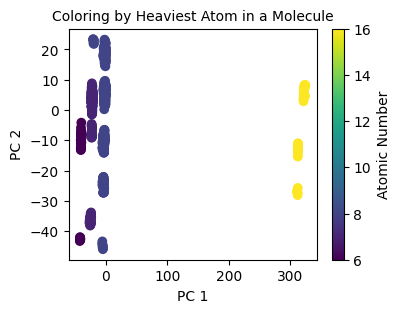

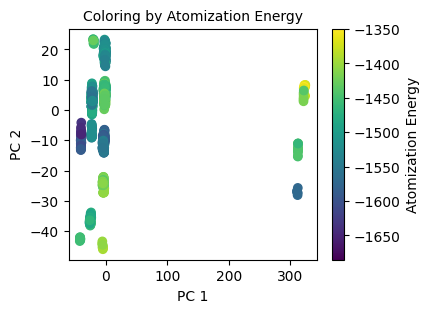

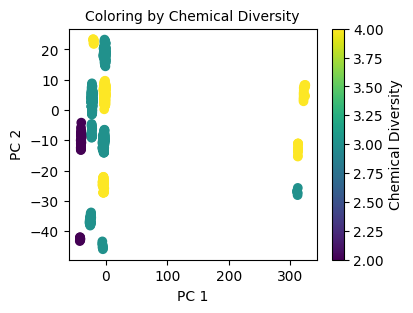

In [114]:
# First plot: Atomic number
plt.figure(figsize=(4, 3))
ax_Z = qm7_data['Z'].max(axis=1)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=max_Z)
plt.colorbar(label='Atomic Number')
plt.title("Coloring by Heaviest Atom in a Molecule", size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

# Second plot: Atomization energy
plt.figure(figsize=(4, 3))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=qm7_data["T"])
plt.colorbar(label='Atomization Energy')
plt.title("Coloring by Atomization Energy", size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

# Third plot: Chemical diversity
plt.figure(figsize=(4, 3))
df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=df_u.nunique(axis=1))
plt.colorbar(label='Chemical Diversity')
plt.title("Coloring by Chemical Diversity", size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

As you can see in the plots above, the first principal component (x-axis) seems to mainly encode information about the heaviest atom in the molecule.

In order to further validate this observation and to show another way of analyzing the principal components, we will split the QM7 data set into two parts according to the PC1 value (> 250 and < 50). Then, we will use Py3Dmol to visualize the structures of the molecule. By visualizing different structures from each of the two PC1 clusters, we will be able to observe that the main difference between them is the presence or absence of sulfur atoms.

In [37]:
# Separate molecules into two clusters
df_pca_cm = pd.DataFrame(X_reduced)
idx_largest_pc1 = df_pca_cm[df_pca_cm[0] > 250].index.tolist()  # Cluster 1
idx_smallest_pc1 = df_pca_cm[df_pca_cm[0] < 50].index.tolist()  # Cluster 2

# Display a molecule from one of the clusters
# Change the number in the rectangular bracets below ([5]) to view different structures from each cluster
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
mol = view_molecule(qm7_data, idx_smallest_pc1[5], s)  # Change `idx_smallest_pc1` to `idx_largest_pc1` to view molecules from the other cluster
mol

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Applying PCA after standardizing the data
After scaling the data properly, each feature should contribute equally to the PCA transformation, allowing the principal components to capture the 'true' underlying patterns in the data set (in this case, the 'chemically meaningful' patterns) without being biased by the varying scales of the original features.

In [39]:
from sklearn.preprocessing import StandardScaler

# Apply standard scaling to the QM7 data set we prepared above (qm7_cm); the scaled
# data is transformed into a DataFrame for further analysis
df_scaled = pd.DataFrame(StandardScaler().fit_transform(qm7_cm))
df_scaled

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,-0.044549,0.722757,-0.483804,-0.465096,-1.047523,-1.275253,-1.402952,-0.467348,-0.102323,-0.025052,...,-1.369330,-2.136465,1.770912,1.724548,-0.346133,-0.170830,1.859144,-0.852049,0.988651,0.0
1,-0.044549,0.725228,-0.476380,0.906262,-1.037807,-1.803589,-1.410930,-0.434049,-0.137355,0.747407,...,-1.334562,-2.136684,1.809340,1.639142,-0.993904,-0.878766,1.846415,1.199059,-1.290658,0.0
2,-0.044549,0.728975,0.744357,-0.458203,-0.183195,-1.803703,-1.411218,0.059881,0.532819,0.029254,...,-1.242912,-2.067548,-0.727372,-0.649023,-0.956618,2.237051,-0.773411,1.185188,-1.295472,0.0
3,-0.044549,0.718454,-0.508503,0.906193,-0.171030,-1.805138,-1.523623,-0.526795,0.517558,0.034193,...,-1.323124,-2.150048,-0.077073,3.578688,-0.494582,2.250263,-0.400732,-0.825875,-1.096336,0.0
4,-0.723964,0.098569,-0.128764,-0.079294,-0.871444,-1.926379,-1.556895,-0.584487,-0.342716,-0.789746,...,-1.223060,-2.135624,-0.818050,-0.728077,2.983373,2.272133,-0.452575,-0.873451,-1.081588,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,-0.418149,0.950632,0.624795,-0.689563,-0.426326,-0.183215,-0.412029,-0.852373,-0.831957,0.463348,...,0.419067,0.556566,-0.442788,-0.179744,-1.095523,-0.843277,0.821287,-1.042932,0.856048,0.0
1215,-0.418149,0.785287,0.626409,-0.664681,-0.305158,-0.210053,-0.270636,-0.890492,-0.761952,-0.728877,...,0.369628,0.535037,-0.336154,-0.653435,1.322095,0.983624,1.844822,1.194901,-1.267976,0.0
1216,-0.723964,-0.125038,-0.934655,0.006048,-0.689139,-0.593179,1.620175,-0.630176,-0.899804,-1.011699,...,-0.623292,0.559996,-0.193912,-0.538604,-0.795345,0.766032,-0.541173,-0.910498,0.847176,0.0
1217,-0.723964,-0.086327,-0.047584,-0.942256,-0.678343,0.985074,-0.047409,-1.102956,-1.064490,-0.284456,...,-0.542386,0.559233,0.961996,0.978596,-0.849560,-0.206499,1.688425,-0.832395,-1.078552,0.0


In [41]:
# Initialize the PCA model with the number of components to keep (in this case, 2)
pca = PCA(n_components=2)

# Fit the PCA model to the standardized data
pca.fit(df_scaled)

# Transform the standardized data to the new PCA space with reduced dimensions
X_reduced_scaled = pca.transform(df_scaled)
X_reduced_scaled

array([[-11.536623  ,  -4.499148  ],
       [-10.823383  ,  -4.3934393 ],
       [-11.393054  ,  -3.8300138 ],
       ...,
       [  0.3270062 ,  -0.13452263],
       [  0.14472926,  -3.0896878 ],
       [  0.5772225 ,  -3.322507  ]], dtype=float32)

Text(0, 0.5, 'PC 2')

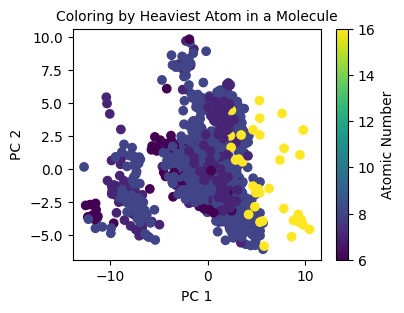

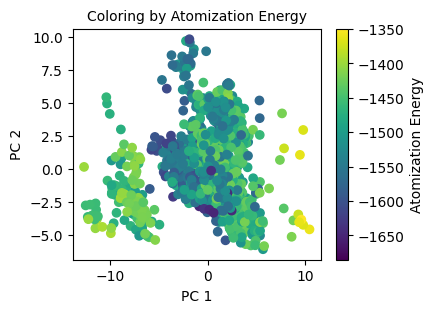

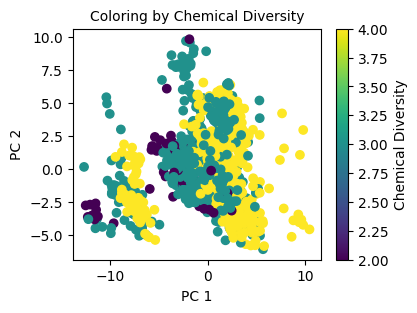

In [116]:
# First plot: Atomic number
plt.figure(figsize=(4, 3))
max_Z = qm7_data['Z'].max(axis=1)
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=max_Z)
plt.colorbar(label='Atomic Number')
plt.title("Coloring by Heaviest Atom in a Molecule", size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

# Second plot: Atomization energy
plt.figure(figsize=(4, 3))
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=qm7_data["T"])
plt.colorbar(label='Atomization Energy')
plt.title("Coloring by Atomization Energy", size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

# Third plot: Chemical diversity
plt.figure(figsize=(4, 3))
df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=df_u.nunique(axis=1))
plt.colorbar(label='Chemical Diversity')
plt.title("Coloring by Chemical Diversity", size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

### Choosing the number of principal components
Choosing the correct number of principal components (PC) is vital to successfully reducing the dimensionality of your data. If the number of PCs is set too low, then not all of the variance in the data may be accounted for, while too many PCs can be redundant. 

To evaluate how many PCs to choose, the explained variance ratio for each PC can be calculated and visualized. 

In the following section, PCA is performed using 8 PCs for both the standardized and unscaled data, then visualized.

[0.06134318 0.04071223 0.03209452 0.03092543 0.02384283 0.02286105
 0.02063532 0.01952679]


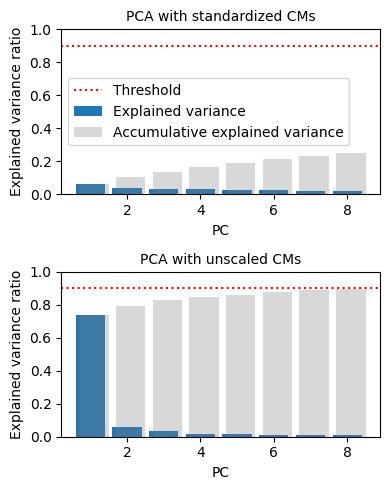

In [123]:
plt.rcParams['figure.figsize'] = [4, 5]

# Plot the explained variance ratio as a function of number of PCs for the standardized data
plt.subplot(2, 1, 1)
pca_scaled = PCA(n_components=8)
pca_scaled.fit(df_scaled)
X_new_scaled = pca_scaled.transform(df_scaled)
pcs_scaled = np.arange(len(pca_scaled.explained_variance_ratio_))+1
print (pca_scaled.explained_variance_ratio_)
s = 0
cumsum = [(s:=s+i) for i in pca_scaled.explained_variance_ratio_]
plt.bar(pcs_scaled, pca_scaled.explained_variance_ratio_,label="Explained variance")
plt.bar(pcs_scaled+0.1, cumsum, color="gray", alpha = 0.3,label="Accumulative explained variance")
plt.title("PCA with standardized CMs", size=10)
plt.xlabel("PC", size=10)
plt.ylabel("Explained variance ratio", size=10)
plt.ylim(0,1)
plt.axhline(y = 0.9, color = 'r', linestyle = ':',label="Threshold")
plt.legend(loc="center left", fontsize=10)

# Plot the explained variance ratio as a function of number of PCs for the unscaled data
plt.subplot(2, 1, 2)
pca = PCA(n_components=8)
pca.fit(df_qm7_cm)
X_new = pca.transform(df_qm7_cm)
pcs = np.arange(len(pca.explained_variance_ratio_))+1
s = 0
cumsum = [(s:=s+i) for i in pca.explained_variance_ratio_]
plt.bar(pcs, pca.explained_variance_ratio_,label="Explained variance")
plt.bar(pcs+0.1, cumsum, color="gray", alpha = 0.3,label="Accumulative explained variance")
plt.title("PCA with unscaled CMs", size=10)
plt.xlabel("PC", size=10)
plt.ylabel("Explained variance ratio", size=10)
plt.ylim(0,1)
plt.axhline(y = 0.9, color = 'r', linestyle = ':')

plt.tight_layout()

plt.show()


#### Summary of applying PCA to scaled versus unscaled Coulomb matrices
Take a closer look at the Coulomb matrices and consider why normalization might be necessary. Why do unnormalized Coulomb matrices lead to seemingly "better" PCA results?

As seen above, the explained variance for the first eight PCs is lower when using the scaled Coulomb matrices compared to when using the unscaled ones. At first glance, the results from the PCA of the unscaled Coulomb matrices may seem more promising, as more variance is explained with fewer principal components. However, this is misleading because it doesn't encode any chemically meaningful variance, but rather only variance due to the heaviest molecule present in each molecule. This is not particularly interesting in this case and doesn't provide any new chemical insights.

This example highlights the importance of inspecting the PCs (e.g., by plotting them according to different values or visualizing a few molecules from one PC range). Normalization ensures that each feature contributes equally to the analysis, preventing features with larger variances from dominating the PCs and skewing the results.

### Interpretation of principal components (PCs)

In [52]:
# Initialize the PCA model to retain the first 8 principal components and fit to the scaled CMs
pca = PCA(n_components=8)
pca.fit(df_scaled)

# Transform the standardized data to the new PCA space with reduced dimensions
X_reduced_scaled = pca.transform(df_scaled)

# Process and print the first 5 lines for the 8 PC eigenvectors
df_importance = pd.DataFrame(pca.components_)
df_importance = df_importance.apply(np.abs)
df_importance = df_importance.transpose()
df_importance.columns = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"]
df_importance.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.091022,0.010974,0.275038,0.106593,0.002441,0.019473,0.008945,0.089520
1,0.048403,0.003755,0.180603,0.146480,0.040991,0.018715,0.003924,0.004959
2,0.037316,0.022107,0.237694,0.141996,0.018058,0.057405,0.030992,0.002179
3,0.080984,0.013563,0.163499,0.044898,0.021530,0.102735,0.105740,0.076901
4,0.072895,0.003039,0.146948,0.003713,0.010502,0.097298,0.088154,0.063329


In [53]:
# Sort the features of the eigenvectors by their importance (larger value == more important)
df_importance["PC1"].sort_values(ascending=False)

96     0.213251
97     0.198511
111    0.198511
126    0.182101
98     0.182101
         ...   
160    0.000000
144    0.000000
128    0.000000
64     0.000000
224    0.000000
Name: PC1, Length: 225, dtype: float32

By analyzing the importance of the original input features in the PCs, we can gain information about which feature (in this case, which term in the CM) influences the PC. This allows us to better 'interpret' the PCs.

### Visualizing the PCs from PCA on the unscaled data
Let's visualize some molecules from the first PCs in the unscaled CM data set, as well as some of the molecules from each of the identified clusters.

In [59]:
# Transform the unscaled data to the new PCA space with reduced dimensions
df_pca_cm = pd.DataFrame(X_reduced)

# Separate molecules into two clusters
idx_largest_pc1 = df_pca_cm[df_pca_cm[0] > 250].index.tolist()
idx_smallest_pc1 = df_pca_cm[df_pca_cm[0] < 50].index.tolist()

In [67]:
# Display the PCs of the transformed data
df_pca_cm

,0,1
0,-5.540398,-45.321301
1,-4.907585,-45.959274
2,-4.565697,-45.632000
3,-4.619194,-45.108738
4,-41.700222,-42.998959
...,...,...
1214,-21.878227,2.886360
1215,-21.924301,3.119583
1216,-40.219597,-7.565445
1217,-39.983810,-7.764687


In [68]:
# Display a molecule from one of the two clusters
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
mol = view_molecule(qm7_data, idx_largest_pc1[5], s)
mol

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [69]:
# Display a molecule from the other cluster
mol = view_molecule(qm7_data, idx_smallest_pc1[22], s)
mol

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

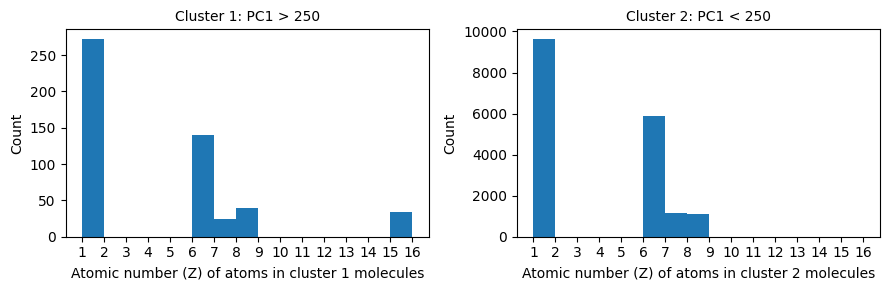

In [104]:
df_X_reduced = pd.DataFrame(X_reduced)

plt.figure(figsize=(9,3))
bins = list(range(1,17))
# First subplot: PC1 > 250
plt.subplot(1, 2, 1)
df_X_reduced_filtered = df_X_reduced.loc[df_X_reduced[0] > 250]
cluster1_Z = pd.DataFrame(qm7_data['Z'][list(df_X_reduced_filtered.index.values)])
# Create a histogram of the data, after stacking all the columns in the dataframe into a long list of values
plt.hist(cluster1_Z.stack(), bins=bins)
plt.xticks(bins)
plt.xlabel('Atomic number (Z) of atoms in cluster 1 molecules')
plt.ylabel('Count')
plt.title('Cluster 1: PC1 > 250', size=10)

# Second subplot: PC1 < 250
plt.subplot(1, 2, 2)
df_X_reduced_filtered = df_X_reduced.loc[df_X_reduced[0] < 250]
cluster2_Z = pd.DataFrame(qm7_data['Z'][list(df_X_reduced_filtered.index.values)])
# Create a histogram of the data, after stacking all the columns in the dataframe into a long list of values
plt.hist(cluster2_Z.stack(), bins=bins)
plt.xticks(bins)
plt.xlabel('Atomic number (Z) of atoms in cluster 2 molecules')
plt.ylabel('Count')
plt.title('Cluster 2: PC1 < 250', size=10)

plt.tight_layout()

plt.show()


To evaluate the separation of molecules by the first PC for the unscaled data set, histograms of the atomic number of atoms in molecules with a PC1 value over or under 250 are plotted above. 

The key difference we see between molecules in both clusters is that molecules with a PC1 value over 250 contain sulfur atoms (Z=16), while molecules with a PC1 value under 250 do not.

## t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a powerful dimensionality reduction algorithm frequently used for visualizing high-dimensional data. By modeling each high-dimensional object by a 2D or 3D point, t-SNE aims to preserve the relative distances between points, thus capturing the underlying structure of the data. 

Below we use t-SNE to reduce the dimensionality of the *standardized* CM data set we prepared above from QM7.

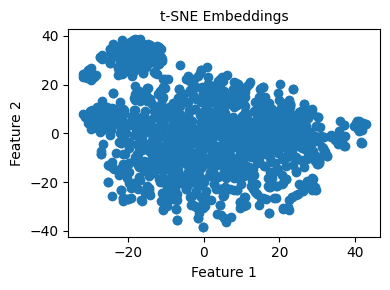

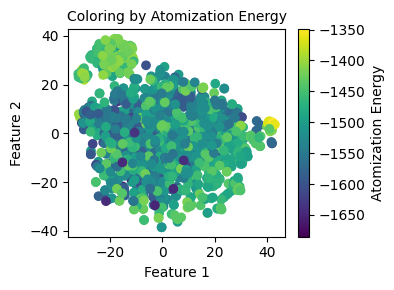

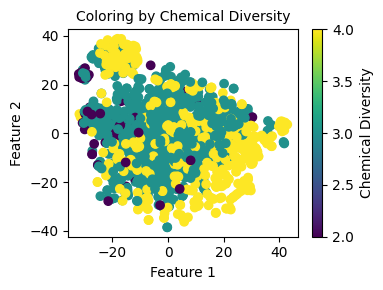

In [128]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensionality of the scaled data set to 2 components for visualization
# learning_rate='auto': Automatically set the learning rate based on the data set size
# init='random': Use random initialization for the embedding
# perplexity=50: Set the perplexity, which affects the balance between local and global aspects of the data
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(df_scaled)


# First plot: A t-SNE plot with no coloring
plt.figure(figsize=(4, 3))
plt.scatter(X_embedded.T[0], X_embedded.T[1])
plt.title("t-SNE Embeddings", size=10)
plt.xlabel('Feature 1', size=10)
plt.ylabel('Feature 2', size=10)
plt.tight_layout()

# Second plot: t-SNE embeddings colored by atomization energy
plt.figure(figsize=(4, 3))
plt.scatter(X_embedded.T[0], X_embedded.T[1], c=qm7_data["T"])
plt.colorbar(label='Atomization Energy')
plt.title("Coloring by Atomization Energy", size=10)
plt.xlabel('Feature 1', size=10)
plt.ylabel('Feature 2', size=10)
plt.tight_layout()

# Third plot: t-SNE embeddings colored by chemical diversity
plt.figure(figsize=(4, 3))
df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_embedded.T[0], X_embedded.T[1], c=df_u.nunique(axis=1))
plt.colorbar(label='Chemical Diversity')
plt.title("Coloring by Chemical Diversity", size=10)
plt.xlabel('Feature 1', size=10)
plt.ylabel('Feature 2', size=10)
plt.tight_layout()